<a href="https://colab.research.google.com/github/ellick-chan/RayNAS/blob/master/mininas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Subject: MiniNAS Neural Architecture Search using SigOpt and Ray Tune

Neural Architecture Search (NAS) is a technique to find optimized neural networks for a given task. Network parameters such as the depth of a network, number of convolutional filters, pooling, epochs and learning rate can affect a network’s accuracy and inference throughput/latency with respect to a dataset. The search space for these parameters is large and NAS can take many compute hours to run. In this article, we illustrate how one can use smarter search algorithms provided by SigOpt paired with raw cluster compute power provided by Ray Tune to accelerate this search process. We illustrate the concepts clearly so that a practitioner can apply this to their workflow.

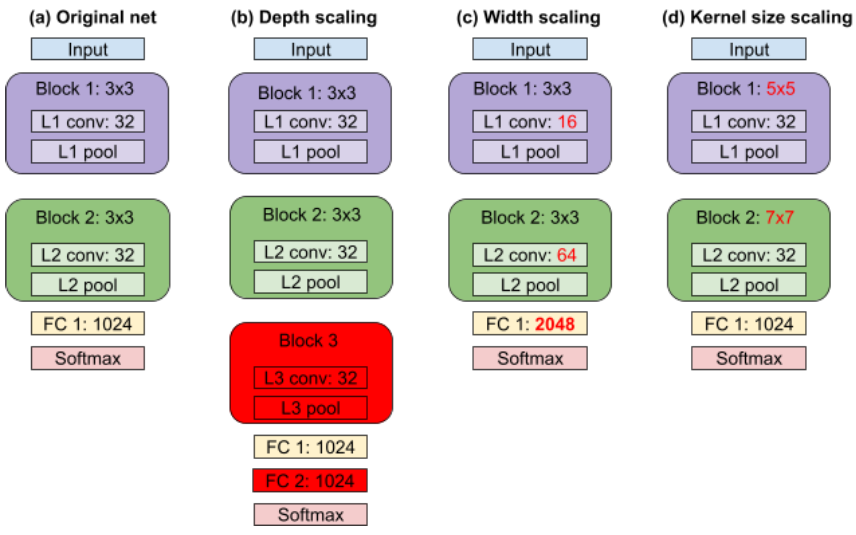

#Overall workflow
Define a neural network training task - choose a dataset and a model template (e.g. convolutional). Parameterize the model (e.g. number of layers/filters)
Apply Ray Tune to search for a good set of model parameters
Adapt search algorithm to SigOpt to get better results faster

## Parameterizing the model
###To parameterize the model, we define the following parameters: 
**Epochs** - the number of epochs to train a model \\
**Layers** - the maximum number of layers of the desired model \\
**Nconv0** - Number of 3x3 convolution filters for the input layer \\
**Nfcll** - Number of fully-connected last layers, with 1024 neurons each \\
 \\
###Convolution block #1 
**Nblocks1** - Number of copies of convolution block #1 \\
**Nconv1** - Number of 3x3 convolution filters for block #1 \\
 \\
###Convolution block #2 
**Nblocks2** - Number of copies of convolution block #2 \\
**Nconv2** - Number of 3x3 convolution filters for block #2 \\
 \\
**Pooling** - global setting to enable/disable pooling in convolution blocks #1/#2


In [ ]:
# Install prerequisites
!pip install -U -qqq ray[tune] tensorflow pandas
!nvidia-smi

In [1]:
import psutil
psutil.cpu_count()

2

In [ ]:
# download dataset
from tensorflow.keras.datasets import cifar10
d = cifar10.load_data()

In [ ]:
def train(config, checkpoint_dir=None):
    import os, numpy as np
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

    # Load the dataset
    (X_train, Y_train), (X_test, Y_test) = keras.datasets.cifar10.load_data()

    # Create the model
    model = Sequential()

    model.add(Conv2D(config['nconv0'], kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
    for i in range(config['nblocks1']):
        if len(model.layers) > config['layers']: break
        model.add(Conv2D(config['nconv1'], kernel_size=(3, 3), activation='relu'))
        if config["pooling"] == "True": model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

    for i in range(config['nblocks2']):
        if len(model.layers) > config['layers']: break
        model.add(Conv2D(config['nconv2'], kernel_size=(3, 3), activation='relu'))
        if config["pooling"] == "True": model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

    model.add(Flatten())
    for i in range(config['nfcll']): # number of fully connected last layers
        if len(model.layers) > config['layers']: break
        model.add(Dense(1024, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    print("Layers: %d max layers: %d" % (len(model.layers), config['layers']))
    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(lr=0.0001, decay=1e-6),
                  metrics=['accuracy'])

    # Train the model
    from tensorflow.keras.utils import to_categorical
    model.fit(X_train / 255.0, to_categorical(Y_train),
              batch_size=128,
              shuffle=True,
              epochs=config["epochs"],
              verbose=0,
              validation_data=(X_test / 255.0, to_categorical(Y_test)),
              callbacks=[keras.callbacks.EarlyStopping(min_delta=0.001, patience=3)])

    scores = model.evaluate(X_test / 255.0, to_categorical(Y_test))
    tune.report({"Accuracy": scores[1], "Loss": scores[0]})


In [ ]:
from ray import tune
config = {
        "epochs":   tune.randint(1, 50),
        "layers":   tune.randint(1, 20),     # max number of layers, layers past this are ignored
        "nconv0":   tune.randint(16, 64),    # input layer
        "nfcll" :   tune.randint(0, 2),      # fully connected last layer

        "nblocks1": tune.randint(1, 3),      # conv block 1
        "nconv1":   tune.randint(16, 64),
        "nblocks2": tune.randint(1, 3),      # conv block 2
        "nconv2":   tune.randint(16, 64),
        "pooling" : tune.choice(['True', 'False'])
    }

In [ ]:
    analysis = tune.run(
        train,
        num_samples=5,
        checkpoint_score_attr="Score",
        resources_per_trial={'gpu': 1},
        raise_on_failed_trial=False, # Some net configs are invalid (pooling too many times creates negative dim)
        config=config)

In [ ]:
analysis.results_df